# Настройки и описание

Тестовый датасет "Linear_Dataset.csv" представляет из себя функцию Y = 0,5 * A + 2 * B + С. А, В, С есть случайное целое число. Модель нейросети - обычная последовательная модель нейросети глубокого обучения с несколькими промежуточными полносвязанными слями Dence и без специализированных дополнительных слоёв. Важно! Код написан для работы с числовыми данными типа int и float.

Подключим Гугл.Диск для сохранения и загрузки моделей

In [1]:
from google.colab import drive
drive.mount('/content/drive')
#! pip install pyyaml h5py  # Требуется для сохранения и загрузки моделей в HDF5-формате

Mounted at /content/drive


Настройки

In [2]:
number_of_interations = 1 #Номер итерации для сохранения и загрузки готовой модели
split_percent = 0.85 # Процент данных для обучения

BATCH_SIZE = 5 # Размер пакета для обучения
EPOCHS = 30 # Количество эпох обучения
NN_optimizer = 'adam' # Оптимизатор для модели НС
NN_loss = 'mse' # Функция потерь
csv_file = 'https://raw.githubusercontent.com/AnLiMan/Machine-Learning-Course/main/Datasets/Linear_Dataset.csv'  # Ссылка на датасет
save_path = "/content/drive/My Drive/Files for colab/GWO_NN_model_" + str(number_of_interations) + ".keras" # Путь для сохранения и загрузки моделей нейронки с гугл диска
print('Текущий номер для сохранения модели, чекпоинтов, а также загрузки существующей модели с облака: ', number_of_interations)

Текущий номер для сохранения модели, чекпоинтов, а также загрузки существующей модели с облака:  1


# Библиотеки

In [3]:
import pandas as pd
import numpy as np
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from keras import layers
from tensorflow import keras
import math
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import random

# Подготовка данных

## Загрузим датасет, выведем некоторую информацию и совершим серию проверок

In [4]:
df = pd.read_csv(csv_file) # Прочтём датасет
df.head() # Выведем заголовок
df.dtypes # Используемые типы данных

A      int64
B      int64
C      int64
Y    float64
dtype: object

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   A       182 non-null    int64  
 1   B       182 non-null    int64  
 2   C       182 non-null    int64  
 3   Y       182 non-null    float64
dtypes: float64(1), int64(3)
memory usage: 5.8 KB
None


In [6]:
print(df.shape)

(182, 4)


Выделим колонку из датасета, которую нужно будет предсказывать в будущем.

In [7]:
target = df.pop('Y')

Выделим все числовые значения из датсета, строк здесь быть не должно. Эти значения будут независимыми переменными для предсказания target

In [8]:
numeric_feature_names = ['A', 'B', 'C']
numeric_features = df[numeric_feature_names]
numeric_features.head()

,A,B,C
0,18,8,0
1,10,24,17
2,9,13,21
3,24,25,7
4,8,8,2


## Преобразуем данные в массив numpy

In [9]:
data = np.array(numeric_features) # Преобразуем в массив numpy с типом данных float32
data2 = np.array(target)

### Разделим данные на тренировочные и тестовые

In [10]:
n = len(data)
split = int(n*split_percent)
train_X = data[range(split)]
test_X = data[split:]
train_Y = data2[range(split)]
test_Y = data2[split:]

Конвертируем train_X в тенсор

In [11]:
tf.convert_to_tensor(train_X)

<tf.Tensor: shape=(154, 3), dtype=int64, numpy=
array([[18,  8,  0],
       [10, 24, 17],
       [ 9, 13, 21],
       [24, 25,  7],
       [ 8,  8,  2],
       [12,  1, 23],
       [23, 18, 15],
       [23, 12,  1],
       [ 6, 21, 17],
       [ 1,  2, 17],
       [24, 18, 23],
       [19,  9, 20],
       [ 7,  0, 13],
       [25, 10, 19],
       [ 1, 16,  9],
       [24, 14, 19],
       [ 8,  4, 21],
       [11,  5, 14],
       [19, 18,  4],
       [21, 24, 13],
       [12, 23,  4],
       [ 3, 20, 25],
       [13, 15, 18],
       [ 4,  2, 17],
       [12, 11, 24],
       [18, 19, 18],
       [ 2, 17, 13],
       [ 5,  2,  7],
       [ 6,  5,  5],
       [10, 24, 16],
       [18, 20,  7],
       [25,  6, 14],
       [10, 12,  4],
       [10, 17, 16],
       [ 8, 24,  3],
       [ 5,  5,  0],
       [23, 14,  7],
       [10,  3, 14],
       [ 5, 17, 11],
       [12,  3, 15],
       [25, 11,  6],
       [25, 14,  9],
       [15,  6,  2],
       [18, 19, 13],
       [ 6,  8, 23],
       

Нормализуем входные данные

In [12]:
scaler = MinMaxScaler()
scaler.fit(train_X)
normalizer = scaler.fit_transform(train_X)

In [13]:
normalizer = tf.keras.layers.Normalization()

# Модель нейросети

In [14]:
def get_basic_model():
  model = tf.keras.models.Sequential([
  normalizer,
  tf.keras.layers.Flatten(input_shape=(train_X.shape)),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1)])

  model.compile(optimizer = NN_optimizer,loss = NN_loss)
  return model

# Обучение нейросети и её сохранение

In [15]:
model = get_basic_model()
history = model.fit(train_X, train_Y, epochs= EPOCHS, batch_size= BATCH_SIZE)
model.summary()
model.save(save_path)

Epoch 1/30
31/31 [==============================] - 1s 4ms/step - loss: 391.3820
Epoch 2/30
31/31 [==============================] - 0s 3ms/step - loss: 9.2098
Epoch 3/30
31/31 [==============================] - 0s 3ms/step - loss: 1.1345
Epoch 4/30
31/31 [==============================] - 0s 4ms/step - loss: 0.4813
Epoch 5/30
31/31 [==============================] - 0s 4ms/step - loss: 0.2882
Epoch 6/30
31/31 [==============================] - 0s 3ms/step - loss: 0.1169
Epoch 7/30
31/31 [==============================] - 0s 3ms/step - loss: 0.0870
Epoch 8/30
31/31 [==============================] - 0s 3ms/step - loss: 0.0870
Epoch 9/30
31/31 [==============================] - 0s 4ms/step - loss: 0.0692
Epoch 10/30
31/31 [==============================] - 0s 4ms/step - loss: 0.0595
Epoch 11/30
31/31 [==============================] - 0s 5ms/step - loss: 0.0398
Epoch 12/30
31/31 [==============================] - 0s 4ms/step - loss: 0.0352
Epoch 13/30
31/31 [============================

# Работа с загруженной моделью

In [16]:
Loading_model = tf.keras.models.load_model(save_path)
Loading_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 3)                 7         
 on)                                                             
                                                                 
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 512)               131584    
                                                        

## Визуализация результатов

## Проверка точности предсказания

### Прогон по тестовой выборке

In [17]:
for i in range(len(test_X)):
  print("Предсказание при вводных данных " + str(test_X[i]) + " = " + str(Loading_model.predict(test_X[i])))
  print ("Реальное значение = "+ str (test_Y[i]))

1/1 [==============================] - 0s 102ms/step
Предсказание при вводных данных [16  6  7] = [[27.056]]
Реальное значение = 27.0
1/1 [==============================] - 0s 23ms/step
Предсказание при вводных данных [19 18  7] = [[52.479]]
Реальное значение = 52.5
1/1 [==============================] - 0s 17ms/step
Предсказание при вводных данных [25  1  5] = [[19.587]]
Реальное значение = 19.5
1/1 [==============================] - 0s 21ms/step
Предсказание при вводных данных [ 6 25 18] = [[71.009]]
Реальное значение = 71.0
1/1 [==============================] - 0s 21ms/step
Предсказание при вводных данных [19 22  5] = [[58.373]]
Реальное значение = 58.5
1/1 [==============================] - 0s 27ms/step
Предсказание при вводных данных [17  1  4] = [[14.574]]
Реальное значение = 14.5
1/1 [==============================] - 0s 22ms/step
Предсказание при вводных данных [4 2 0] = [[6.091]]
Реальное значение = 6.0
1/1 [==============================] - 0s 19ms/step
Предсказание при ввод

1/1 [==============================] - 0s 27ms/step


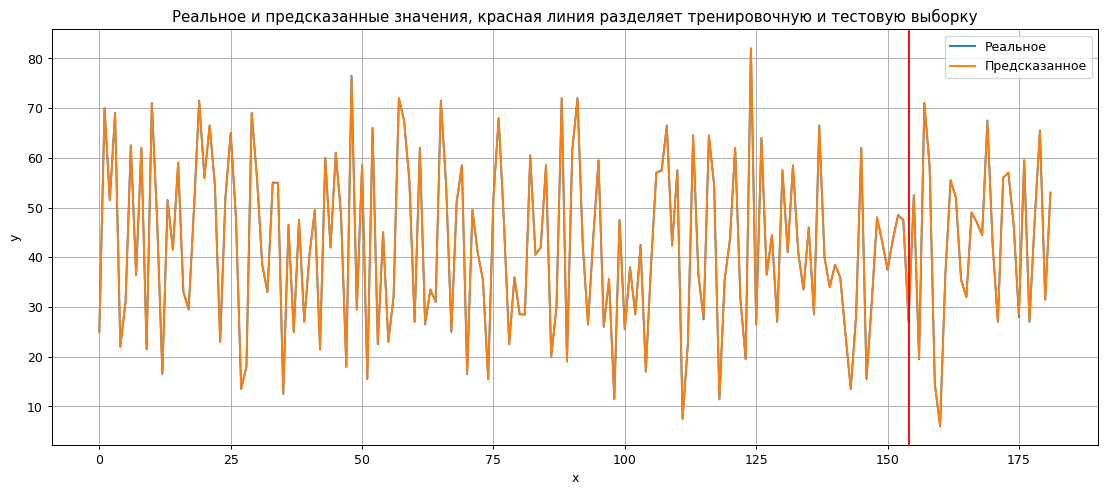

In [18]:
# Графики истиннных значений и предсказаний
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=90)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Реальное', 'Предсказанное'])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Реальное и предсказанные значения, красная линия разделяет тренировочную и тестовую выборку')
    plt.grid()

# Сделаем предсказания
train_predict = Loading_model.predict(train_X)
test_predict = Loading_model.predict(test_X)
plot_result(train_Y, test_Y, train_predict, test_predict)

### Проверка только на тестовой выборке

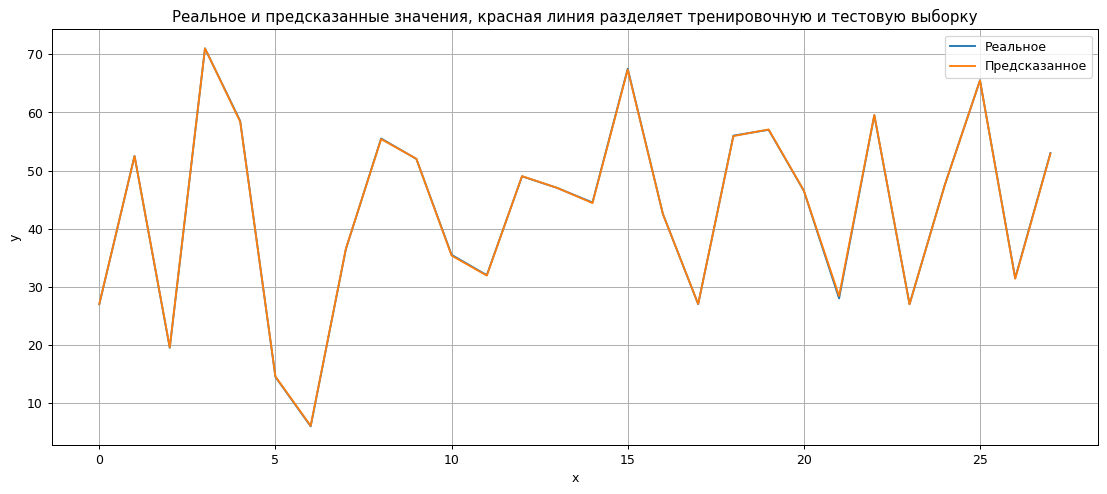

In [19]:
def plot_result(testY , test_predict):
    plt.figure(figsize=(15, 6), dpi=90)
    plt.plot(testY)
    plt.plot(test_predict)
    plt.legend(['Реальное', 'Предсказанное'])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Реальное и предсказанные значения, красная линия разделяет тренировочную и тестовую выборку')
    plt.grid()
plot_result(test_Y, test_predict)

# Алгоритм оптимизации стаи серых волков GWO для поиска глобального минимума функции

In [20]:
#----Переменные---
iter_number_list = [] #Список значений х для графика
pop = 15 #Численность популяции волков
lb = [0, 0, 0] #Список, нижняя граница (lower boundary) i-го компонента равна lb[i]
ub = [25, 25, 25] #Список, верхняя граница (upper boundary) i-го компонента равна ub[i]
iter = 15 # Количество итераций для алгоритма
round_of_solution = 4 #До кагого знака округляем результаты оптимизации
a_list = [] #Список значений "а"
y_optimized = []

#Инициализация и формулирование проблемы (см. формулы из "Pressure vessel design")
def obj(x):
    print("Вычисление позиции омеги...")
    return Loading_model.predict(x)

#Проверка границ
def boundary_check(x, lb, ub, dim):
    for i in range(dim):
        if x[i] < lb[i]:
            x[i] = lb[i]
        elif x[i] > ub[i]:
            x[i] = ub[i]
    return x

#Основная функция
def main(pop, lb, ub, iter):
    # Шаг 1. Инициализация
    dim = len(ub)  # размерность
    pos = []
    score = []
    iter_best = []  # Наилучшее решение каждой итерации
    for _ in range(pop):
        temp_pos = [random.uniform(lb[i], ub[i]) for i in range(dim)]
        temp_score = obj(temp_pos)
        pos.append(temp_pos)
        score.append(temp_score)
    sorted_score = sorted(score)
    alpha_score = sorted_score[0]
    alpha_pos = pos[score.index(alpha_score)].copy()
    beta_score = sorted_score[1]
    beta_pos = pos[score.index(beta_score)].copy()
    delta_score = sorted_score[2]
    delta_pos = pos[score.index(delta_score)].copy()
    iter_best.append(alpha_score)

    # Шаг 2. Основной цикл
    for t in range(iter):
        iter_number_list.append(t)
        a = 2 - 2 * (t + 1) / iter
        a_list.append(a)
        for i in range(pop):
            for j in range(dim):
                # Вычисление расстояния между альфа
                r1 = random.random()
                r2 = random.random()
                A1 = 2 * a * r1 - a
                C1 = 2 * r2
                D_alpha = abs(C1 * alpha_pos[j] - pos[i][j])
                X1 = alpha_pos[j] - A1 * D_alpha

                # Вычисление расстояния между бета
                r1 = random.random()
                r2 = random.random()
                A2 = 2 * a * r1 - a
                C2 = 2 * r2
                D_alpha = abs(C2 * beta_pos[j] - pos[i][j])
                X2 = beta_pos[j] - A2 * D_alpha

                # Вычисление расстояния между дельта
                r1 = random.random()
                r2 = random.random()
                A3 = 2 * a * r1 - a
                C3 = 2 * r2
                D_alpha = abs(C3 * delta_pos[j] - pos[i][j])
                X3 = delta_pos[j] - A3 * D_alpha

                #Вычисление позиции для агента (омега)
                pos[i][j] = (X1 + X2 + X3) / 3

            # Проверка выхода за границы
            pos[i] = boundary_check(pos[i], lb, ub, dim)

            # Обновление "счёта"
            score[i] = obj(np.array(pos[i]))
            if score[i] < alpha_score:
                alpha_score = score[i]
                alpha_pos = pos[i].copy()
            elif score[i] < beta_score:
                beta_score = score[i]
                beta_pos = pos[i].copy()
            elif score[i] < delta_score:
                delta_score = score[i]
                delta_pos = pos[i].copy()

        iter_best.append(alpha_score)
        y_optimized.append(Loading_model.predict(alpha_score))
        print("\n После итерации " + str(t) + " результат оптимизации = " + str(y_optimized[t]))

    iter_number_list.append(iter + 1)
    a_list.append(0)

    print("\n -----Итоговое решение-----")
    print("A =", round(alpha_pos[0], round_of_solution), "B =", round(alpha_pos[1], round_of_solution + 2), "C =", round(alpha_pos[2], round_of_solution))
    print("Лучший счёт =" + str(alpha_score))

#----Основной код----
main(pop, lb, ub, iter)

Вычисление позиции омеги...
1/1 [==============================] - 0s 87ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 39ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 32ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 32ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 33ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 32ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 33ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 39ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 31ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 32ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 33ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 34ms/step
Вычисление позиции омеги...
1/1 [=======

# Проверка алгоритма на основе функции Бута f(x,y)= (x+2y-7)^2+ (2x+y-5)^2

Настройки

In [42]:
number_of_interations = 2 #Номер итерации для сохранения и загрузки готовой модели
split_percent = 0.85 # Процент данных для обучения

BATCH_SIZE = 8 # Размер пакета для обучения
EPOCHS = 50 # Количество эпох обучения
NN_optimizer = 'adam' # Оптимизатор для модели НС
NN_loss = 'mse' # Функция потерь
csv_file = 'https://raw.githubusercontent.com/AnLiMan/Grey_Wolf_Optimization/main/Boot_dataset.csv'  # Ссылка на датасет
save_path = "/content/drive/My Drive/Files for colab/NN for diss/NN_model_" + str(number_of_interations) + ".keras" # Путь для сохранения и загрузки моделей нейронки с гугл диска
print('Текущий номер для сохранения модели, чекпоинтов, а также загрузки существующей модели с облака: ', number_of_interations)

Текущий номер для сохранения модели, чекпоинтов, а также загрузки существующей модели с облака:  2


In [22]:
df = pd.read_csv(csv_file) # Прочтём датасет
df.head() # Выведем заголовок
df.dtypes # Используемые типы данных

x    float64
y    float64
f    float64
dtype: object

In [23]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231 entries, 0 to 230
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       231 non-null    float64
 1   y       231 non-null    float64
 2   f       231 non-null    float64
dtypes: float64(3)
memory usage: 5.5 KB
None


In [24]:
print(df.shape)

(231, 3)


In [25]:
target = df.pop('f')

In [26]:
numeric_feature_names = ['x', 'y']
numeric_features = df[numeric_feature_names]
numeric_features.head()

,x,y
0,0.0,0.0
1,0.1,0.1
2,0.2,0.2
3,0.3,0.3
4,0.4,0.4


In [27]:
data = np.array(numeric_features) # Преобразуем в массив numpy с типом данных float32
data2 = np.array(target)

In [28]:
n = len(data)
split = int(n*split_percent)
train_X = data[range(split)]
test_X = data[split:]
train_Y = data2[range(split)]
test_Y = data2[split:]

In [29]:
tf.convert_to_tensor(train_X)

<tf.Tensor: shape=(196, 2), dtype=float64, numpy=
array([[ 0. ,  0. ],
       [ 0.1,  0.1],
       [ 0.2,  0.2],
       [ 0.3,  0.3],
       [ 0.4,  0.4],
       [ 0.5,  0.5],
       [ 0.6,  0.6],
       [ 0.7,  0.7],
       [ 0.8,  0.8],
       [ 0.9,  0.9],
       [ 1. ,  1. ],
       [ 1.1,  1.1],
       [ 1.2,  1.2],
       [ 1.3,  1.3],
       [ 1.4,  1.4],
       [ 1.5,  1.5],
       [ 1.6,  1.6],
       [ 1.7,  1.7],
       [ 1.8,  1.8],
       [ 1.9,  1.9],
       [ 2. ,  2. ],
       [ 2.1,  2.1],
       [ 2.2,  2.2],
       [ 2.3,  2.3],
       [ 2.4,  2.4],
       [ 2.5,  2.5],
       [ 2.6,  2.6],
       [ 2.7,  2.7],
       [ 2.8,  2.8],
       [ 2.9,  2.9],
       [ 3. ,  3. ],
       [ 3.1,  3.1],
       [ 3.2,  3.2],
       [ 3.3,  3.3],
       [ 3.4,  3.4],
       [ 3.5,  3.5],
       [ 3.6,  3.6],
       [ 3.7,  3.7],
       [ 3.8,  3.8],
       [ 3.9,  3.9],
       [ 4. ,  4. ],
       [ 4.1,  4.1],
       [ 4.2,  4.2],
       [ 4.3,  4.3],
       [ 4.2,  4.4],
     

In [30]:
scaler = MinMaxScaler()
scaler.fit(train_X)
normalizer = scaler.fit_transform(train_X)

In [31]:
normalizer = tf.keras.layers.Normalization()

In [37]:
def get_basic_model():
  model = tf.keras.models.Sequential([
  normalizer,
  tf.keras.layers.Flatten(input_shape=(train_X.shape)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dense(1)])

  model.compile(optimizer = NN_optimizer,loss = NN_loss)
  return model

In [43]:
model = get_basic_model()
history = model.fit(train_X, train_Y, epochs= EPOCHS, batch_size= BATCH_SIZE)
model.summary()
model.save(save_path)

Epoch 1/50
25/25 [==============================] - 1s 8ms/step - loss: 3099.4968
Epoch 2/50
25/25 [==============================] - 0s 8ms/step - loss: 814.9758
Epoch 3/50
25/25 [==============================] - 0s 8ms/step - loss: 741.0201
Epoch 4/50
25/25 [==============================] - 0s 9ms/step - loss: 763.3929
Epoch 5/50
25/25 [==============================] - 0s 9ms/step - loss: 696.7770
Epoch 6/50
25/25 [==============================] - 0s 9ms/step - loss: 698.6058
Epoch 7/50
25/25 [==============================] - 0s 8ms/step - loss: 724.3865
Epoch 8/50
25/25 [==============================] - 0s 8ms/step - loss: 662.6589
Epoch 9/50
25/25 [==============================] - 0s 8ms/step - loss: 594.5784
Epoch 10/50
25/25 [==============================] - 0s 10ms/step - loss: 518.6467
Epoch 11/50
25/25 [==============================] - 0s 8ms/step - loss: 456.7422
Epoch 12/50
25/25 [==============================] - 0s 9ms/step - loss: 409.8572
Epoch 13/50
25/25 [====

In [44]:
Loading_model = tf.keras.models.load_model(save_path)
Loading_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 2)                 5         
 tion)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 2)                 0         
                                                                 
 dense_25 (Dense)            (None, 128)               384       
                                                                 
 dense_26 (Dense)            (None, 256)               33024     
                                                                 
 dense_27 (Dense)            (None, 512)               131584    
                                                                 
 dense_28 (Dense)            (None, 1024)              525312    
                                                      

In [45]:
for i in range(len(test_X)):
  print("Предсказание при вводных данных " + str(test_X[i]) + " = " + str(Loading_model.predict(test_X[i])))
  print ("Реальное значение = "+ str (test_Y[i]))

1/1 [==============================] - 0s 69ms/step
Предсказание при вводных данных [ 5.  -4.4] = [[123.316]]
Реальное значение = 117.0
1/1 [==============================] - 0s 18ms/step
Предсказание при вводных данных [ 5.1 -4.6] = [[129.202]]
Реальное значение = 123.57
1/1 [==============================] - 0s 19ms/step
Предсказание при вводных данных [ 5.2 -4.8] = [[135.16]]
Реальное значение = 130.32
1/1 [==============================] - 0s 18ms/step
Предсказание при вводных данных [ 5.3 -5. ] = [[141.173]]
Реальное значение = 137.25
1/1 [==============================] - 0s 18ms/step
Предсказание при вводных данных [ 5.4 -5.2] = [[147.214]]
Реальное значение = 144.36
1/1 [==============================] - 0s 18ms/step
Предсказание при вводных данных [ 5.5 -5.4] = [[153.24]]
Реальное значение = 151.65
1/1 [==============================] - 0s 18ms/step
Предсказание при вводных данных [ 5.6 -5.6] = [[159.254]]
Реальное значение = 159.12
1/1 [==============================] - 0s 20

2/2 [==============================] - 0s 5ms/step


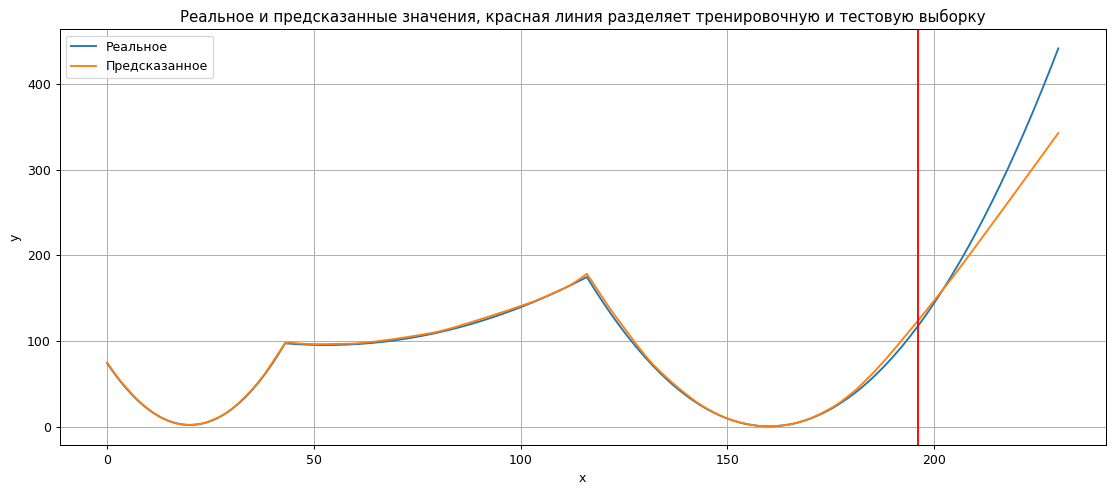

In [46]:
# Графики истиннных значений и предсказаний
def plot_result(trainY, testY, train_predict, test_predict):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 6), dpi=90)
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Реальное', 'Предсказанное'])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Реальное и предсказанные значения, красная линия разделяет тренировочную и тестовую выборку')
    plt.grid()

# Сделаем предсказания
train_predict = Loading_model.predict(train_X)
test_predict = Loading_model.predict(test_X)
plot_result(train_Y, test_Y, train_predict, test_predict)

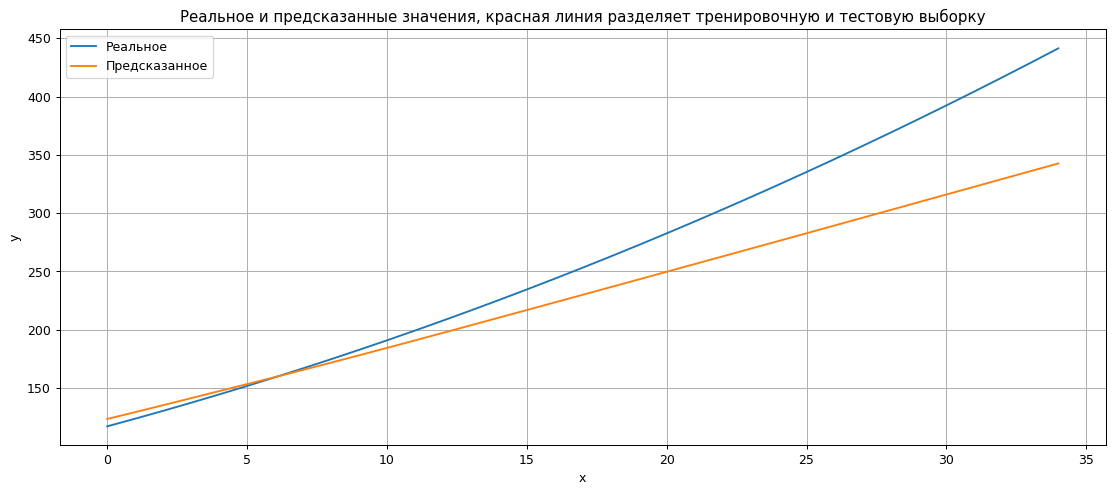

In [47]:
def plot_result(testY , test_predict):
    plt.figure(figsize=(15, 6), dpi=90)
    plt.plot(testY)
    plt.plot(test_predict)
    plt.legend(['Реальное', 'Предсказанное'])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Реальное и предсказанные значения, красная линия разделяет тренировочную и тестовую выборку')
    plt.grid()
plot_result(test_Y, test_predict)

Поиск с GWO

In [50]:
#----Переменные---
iter_number_list = [] #Список значений х для графика
pop = 15 #Численность популяции волков
lb = [-10, -10] #Список, нижняя граница (lower boundary) i-го компонента равна lb[i]
ub = [10, 10] #Список, верхняя граница (upper boundary) i-го компонента равна ub[i]
iter = 15 # Количество итераций для алгоритма
round_of_solution = 4 #До кагого знака округляем результаты оптимизации
a_list = [] #Список значений "а"
y_optimized = []

#Инициализация и формулирование проблемы (см. формулы из "Pressure vessel design")
def obj(x):
    print("Вычисление позиции омеги...")
    return Loading_model.predict(x)

#Проверка границ
def boundary_check(x, lb, ub, dim):
    for i in range(dim):
        if x[i] < lb[i]:
            x[i] = lb[i]
        elif x[i] > ub[i]:
            x[i] = ub[i]
    return x

#Основная функция
def main(pop, lb, ub, iter):
    # Шаг 1. Инициализация
    dim = len(ub)  # размерность
    pos = []
    score = []
    iter_best = []  # Наилучшее решение каждой итерации
    for _ in range(pop):
        temp_pos = [random.uniform(lb[i], ub[i]) for i in range(dim)]
        temp_score = obj(temp_pos)
        pos.append(temp_pos)
        score.append(temp_score)
    sorted_score = sorted(score)
    alpha_score = sorted_score[0]
    alpha_pos = pos[score.index(alpha_score)].copy()
    beta_score = sorted_score[1]
    beta_pos = pos[score.index(beta_score)].copy()
    delta_score = sorted_score[2]
    delta_pos = pos[score.index(delta_score)].copy()
    iter_best.append(alpha_score)

    # Шаг 2. Основной цикл
    for t in range(iter):
        iter_number_list.append(t)
        a = 2 - 2 * (t + 1) / iter
        a_list.append(a)
        for i in range(pop):
            for j in range(dim):
                # Вычисление расстояния между альфа
                r1 = random.random()
                r2 = random.random()
                A1 = 2 * a * r1 - a
                C1 = 2 * r2
                D_alpha = abs(C1 * alpha_pos[j] - pos[i][j])
                X1 = alpha_pos[j] - A1 * D_alpha

                # Вычисление расстояния между бета
                r1 = random.random()
                r2 = random.random()
                A2 = 2 * a * r1 - a
                C2 = 2 * r2
                D_alpha = abs(C2 * beta_pos[j] - pos[i][j])
                X2 = beta_pos[j] - A2 * D_alpha

                # Вычисление расстояния между дельта
                r1 = random.random()
                r2 = random.random()
                A3 = 2 * a * r1 - a
                C3 = 2 * r2
                D_alpha = abs(C3 * delta_pos[j] - pos[i][j])
                X3 = delta_pos[j] - A3 * D_alpha

                #Вычисление позиции для агента (омега)
                pos[i][j] = (X1 + X2 + X3) / 3

            # Проверка выхода за границы
            pos[i] = boundary_check(pos[i], lb, ub, dim)

            # Обновление "счёта"
            score[i] = obj(np.array(pos[i]))
            if score[i] < alpha_score:
                alpha_score = score[i]
                alpha_pos = pos[i].copy()
            elif score[i] < beta_score:
                beta_score = score[i]
                beta_pos = pos[i].copy()
            elif score[i] < delta_score:
                delta_score = score[i]
                delta_pos = pos[i].copy()

        iter_best.append(alpha_score)
        y_optimized.append(Loading_model.predict(alpha_score))
        print("\n После итерации " + str(t) + " результат оптимизации = " + str(y_optimized[t]))

    iter_number_list.append(iter + 1)
    a_list.append(0)

    print("\n -----Итоговое решение-----")
    print("A =", round(alpha_pos[0], round_of_solution), "B =", round(alpha_pos[1], round_of_solution + 2))
    print("Лучший счёт =" + str(alpha_score))

#----Основной код----
main(pop, lb, ub, iter)

Вычисление позиции омеги...
1/1 [==============================] - 0s 33ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 33ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 35ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 35ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 36ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 38ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 53ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 57ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 60ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 56ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 53ms/step
Вычисление позиции омеги...
1/1 [==============================] - 0s 60ms/step
Вычисление позиции омеги...
1/1 [=======